<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Heatmap_each_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Improve accuracy:

```
1. Move top1 towards top2 by 1/4

```

* Ablation study

```
1. Anneal range (1-3 or 1-100)
2. Leaf Node dimension
3. Number of Trees
4. Stack Hourglass or One Hourglass
```

In [1]:
!nvidia-smi

Sun Jul 11 10:02:44 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    23W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
# function ConnectButton(){
#   console.log("Connect pushed"); 
#   document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click() 
# }
# setInterval(ConnectButton,60000);


# clearInterval(37042)

# 1. Initialize

In [2]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['Procruses Analysis.ipynb',
 'PCA.ipynb',
 '__pycache__',
 'utils',
 'datasets',
 'Gaussian.ipynb',
 'Heatmap_all.ipynb',
 'trained_models',
 'checkpoints',
 'Update_leaf.ipynb',
 'Solve_RF_increase.ipynb',
 'Heatmap_each_Test_NME.ipynb',
 'Heatmap_each_Fullset_Fullpoints.ipynb',
 'DataPreprocessing.ipynb',
 'Landmarks_Correlation.ipynb',
 'Untitled0.ipynb',
 'Heatmap_each.ipynb']

In [3]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import cv2
import json
import pandas as pd
from PIL import Image
import torchvision.models as models
import pdb
from torch.nn import Upsample
from torch.autograd import Variable
import torch.optim as optim
import time

import warnings
warnings.filterwarnings('ignore')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from utils.hourglass import *
from utils.dataloader import *

In [5]:
# Landmarks Group
group_landmarks = torch.tensor([8, 3, 3, 3, 3, 6, 6, 6, 6, 6,
                 4, 4, 4, 4, 5, 5, 5, 8, 8, 8, 
                 8, 9, 1, 1, 1, 1, 1, 9, 9, 0, 
                 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 
                 9, 9, 7, 7, 7, 7, 7, 7, 2, 2, 
                 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 
                 2, 2, 2, 2, 2, 2, 2, 2]).to(device)

# 0:7  1:5  2:20  3:4  4:4
# 5:3  6:5  7:6  8:5  9:9

Num_Clusters = 10

cluster_len = torch.tensor([7,5,20,4,4,3,5,6,5,9]).to(device)
dim_tree = torch.tensor([5,5,6,5,5,5,5,5,5,5]).to(device)
num_tree = torch.tensor([2,2,3,1,1,1,2,2,2,3]).to(device)
variance_gaussian = 3

num_fc = torch.sum(num_tree*(2**(dim_tree-1)-1)).item()
num_leaf_nodes = num_tree*2**(dim_tree-1)
total_num_leaf_nodes = torch.sum(num_leaf_nodes).item()

# 2. Data Loader

In [ ]:
helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)
train_dataloder = DataLoader(helen_trainset, batch_size=10, shuffle=True, drop_last=True)

Loading [1/2000] pictures......


In [ ]:
helen_testset = Helen_set(dataset_type="test",var=variance_gaussian)
test_dataloder = DataLoader(helen_testset, batch_size=30)

Loading [1/330] pictures......
Loading [200/330] pictures......


# 3. Pre Train

In [ ]:
# helen_trainset = Helen_set(dataset_type="train",var=variance_gaussian)
# train_dataloder = DataLoader(helen_trainset, batch_size=10, shuffle=True)

Loading [1/2000] pictures......
Loading [400/2000] pictures......
Loading [800/2000] pictures......
Loading [1200/2000] pictures......
Loading [1600/2000] pictures......
Loading [2000/2000] pictures......


In [ ]:
# critical = torch.nn.MSELoss()

# nIters = 200
# HGNet = HGNet().to(device)
# optimizer = optim.SGD(HGNet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

Iter [1/200] loss 0.415810
Iter [5/200] loss 0.147527
Iter [10/200] loss 0.053415
Iter [15/200] loss 0.027352
Iter [20/200] loss 0.015622
Iter [25/200] loss 0.008033
Iter [30/200] loss 0.004600
Iter [35/200] loss 0.002712
Iter [40/200] loss 0.001132
Iter [45/200] loss 0.000598
Iter [50/200] loss 0.000377
Iter [55/200] loss 0.000329
Iter [60/200] loss 0.000263
Iter [65/200] loss 0.000295
Iter [70/200] loss 0.000180
Iter [75/200] loss 0.000147
Iter [80/200] loss 0.000140
Iter [85/200] loss 0.000140
Iter [90/200] loss 0.000111
Iter [95/200] loss 0.000160
Iter [100/200] loss 0.000093
Iter [105/200] loss 0.000077
Iter [110/200] loss 0.000065
Iter [115/200] loss 0.000058
Iter [120/200] loss 0.000065
Iter [125/200] loss 0.000059
Iter [130/200] loss 0.000068
Iter [135/200] loss 0.000048
Iter [140/200] loss 0.000064
Iter [145/200] loss 0.000048
Iter [150/200] loss 0.000054
Iter [155/200] loss 0.000056
Iter [160/200] loss 0.000039
Iter [160/200] loss 0.000039
Iter [160/200] loss 0.000039
Iter [1

Text(0.5, 1.0, 'Training Loss')

Text(0.5, 1.0, 'Training Loss')

Text(0.5, 1.0, 'Training Loss')

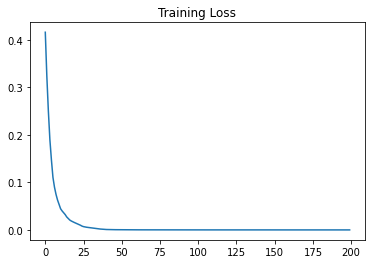

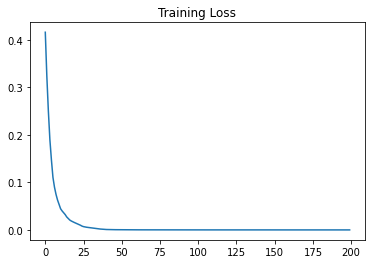

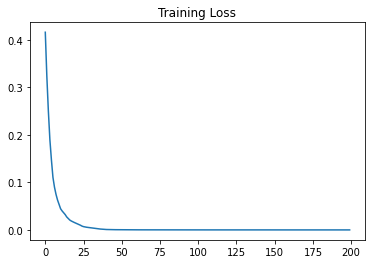

In [ ]:
# loss_hist = torch.zeros(nIters)
# loss_epoch = torch.zeros(200)

# for iter in range(nIters):
#   for i, (x,_,y) in enumerate(train_dataloder):
#     x = Variable(x,requires_grad=True).float().to(device)
#     y = Variable(y).float().to(device)
#     y_pred = HGNet.forward(x)
#     loss = critical(y_pred, y)
#     loss_epoch[i] = loss.item()

#     if i == 199:
#       loss_avg = torch.sum(loss_epoch)/200
#       loss_hist[iter] = loss_avg
#       if (iter+1)%5 == 0 or iter == 0:
#         print('Iter [%d/%d] loss %.6f' %(iter+1, nIters, loss_avg))
        
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

# plt.plot(torch.arange(nIters),loss_hist.detach().numpy())
# plt.title("Training Loss")

In [ ]:
# torch.save(HGNet.state_dict(), "trained_models/Stacked_HGNet.pt")

Test

# 4. Tune Training

## 4.1 Functions

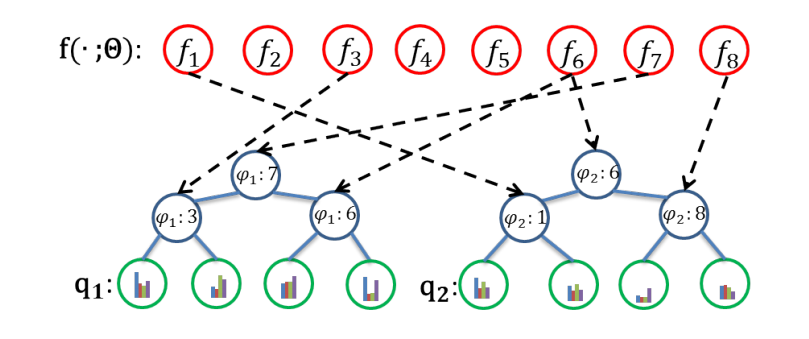

In [ ]:
def leaf_direction(N):
  point = torch.zeros(2**N,N).to(device)

  def get01(number, len):
    result = torch.zeros(len).to(device)
    ind = len
    while ind >0:
      if 2**(ind-1)<=number:
        result[len-ind] = 1
        number -= 2**(ind-1)
      ind -= 1
    return result
  
  for i in range(2**N):
    point[i,:] = get01(i,N)

  return point.int()

In [ ]:
def split_tree(up,here,which=0,mode='Second'):
  if mode=='initial':
    if which == 0:
      return here
    else: return (1-here)
  else:
    if which == 0:
      return up*here
    else: return up*(1-here)

In [ ]:
def split_base(N):
  # returns index that split based on which cnn_fc col
  res = torch.zeros(2**N*N).to(device)
  lenth = 2**(N-1)
  num = 1
  left = 0
  repeat = 1
  max_repeat = 1
  while lenth>0 and repeat<2**N:
    res[left:left+lenth*2] = num
    left += lenth*2
    num += 1
    repeat -= 1
    if repeat == 0:
      lenth = int(lenth/2)
      repeat = max_repeat*2
      max_repeat = repeat
  return ((res.reshape(N,2**N)-1).T).int()

In [ ]:
def phi(cnn_fc,mode='train'):
  N = cnn_fc.shape[0]
  out = torch.zeros(N,total_num_leaf_nodes).to(device)
  sigm = torch.zeros(cnn_fc.shape).to(device)

  if mode == 'test':
    sigm[cnn_fc>0] = 1
  else:
    sigm = torch.sigmoid(cnn_fc)

  for cluster_ind in range(Num_Clusters):
    the_dim_tree = dim_tree[cluster_ind].item()
    the_num_tree = num_tree[cluster_ind].item()
    out_y = torch.sum(num_leaf_nodes[0:cluster_ind]).item()

    direction = leaf_direction(the_dim_tree-1)
    tree_ind = split_base(the_dim_tree-1)
    X, Y = tree_ind.shape

    for ind_tree in range(the_num_tree):
      for x in range(X):
        for y in range(Y):
          here = sigm[:,ind_tree*(X-1)+tree_ind[x,y]]
          if y == 0:
            up = split_tree(torch.rand(3).to(device),here,which=direction[x,y],mode='initial')
          else:
            up = split_tree(up,here,which=direction[x,y])
          #print('y',y,'up',up)

        out[:,out_y+ind_tree*X+x] = up
    
  return out

In [ ]:
def find_coord(prob_map, P):
  # prob_map(200,68*256*256)
  # P: number of points
  N = prob_map.shape[0]

  coord = torch.zeros(N,P*2).to(device)
  heatmap = prob_map.reshape(N,P,256,256).float()
  for n in range(N):
    for p in range(P):
      c1, c2 = torch.where(heatmap[n,p,:,:]==torch.max(heatmap[n,p,:,:]))
      coord[n,2*p], coord[n,2*p+1] = c1[0], c2[0]

  return coord

In [ ]:
def get_mask(cnn_heatmaps,threshold=0.3):
  mask = torch.zeros(cnn_heatmaps.shape).to(device)
  B, P = cnn_heatmaps.shape[0:2]
  for b in range(B):
    for p in range(P):
      hm = cnn_heatmaps[b,p,:,:]
      mask[b,p,:,:][hm>torch.max(hm)*threshold]=1
  return mask

In [ ]:
def update_iter(q, p, l):
  # q: leaf node
  # p: cnn probability
  # l: label

  gamma = torch.unsqueeze(p,2)*torch.unsqueeze(q,0) # (Ntrain,Nleaf,Nlabel)
  gamma = gamma/(torch.sum(gamma,axis=1,keepdims=True)+1e-8)
  score = torch.zeros(gamma.shape).to(q.device)
  for ll in range(q.shape[0]):
    score[:,ll,:] = l*gamma[:,ll,:]
  score = torch.sum(score,axis=0)+1e-8 # (3,2)

  return score/torch.sum(score,axis=1,keepdims=True)

In [ ]:
# def loss_ce(B, q, p, l):
#   pred = torch.matmul(p,q.reshape(num_leaf_nodes,-1)).reshape(B*12,-1)
#   pred = pred/torch.sum(pred,axis=1,keepdims=True)
#   l = l.reshape(B*12,-1)
#   l = l/torch.sum(l,axis=1,keepdims=True)

#   return -criterion_KL(l,pred)

# def loss_l1(q, p, l):
#   return torch.sum(torch.abs(torch.matmul(p,q)-l))/l.shape[0]

def loss_alogb(B, q, p, l):
  np = q.shape[1]
  pred = torch.matmul(p,q.reshape(q.shape[0],-1)).reshape(B*np,-1)
  pred = pred/torch.sum(pred,axis=1,keepdims=True)
  l = l.reshape(B*np,-1)
  l = l/torch.sum(l,axis=1,keepdims=True)

  return -torch.sum(l*torch.log(pred))/B

In [ ]:
# def mask_and_norm(target, mask):
#   # target (B,12,256,256)
#   # mask (B,12,256,256)
#   B,P = target.shape[0:2]

#   res = (target*mask).reshape(B,P,-1)
#   res = res/torch.sum(res,axis=2,keepdims=True)
#   return res.reshape(B,-1)

In [ ]:
def get_heatmap_full(cnn_prob, leaf_q):
  # cnn_prob (B,total_num_leaf_nodes)
  # leaf_q, dict, each (nleaf, ncluster, 256, 256)
  B = cnn_prob.shape[0]
  heatmap = torch.zeros(B,68,256,256).to(device)

  for cluster_ind in range(Num_Clusters):
    nleaf_start = torch.sum(num_leaf_nodes[0:cluster_ind]).item()
    nleaf_end = torch.sum(num_leaf_nodes[0:cluster_ind+1]).item()
    pts_start = torch.sum(cluster_len[0:cluster_ind]).item()
    pts_end = torch.sum(cluster_len[0:cluster_ind+1]).item()

    this_prob = cnn_prob[:,nleaf_start:nleaf_end]
    this_leaf_q = leaf_q[cluster_ind]
    q1,q2 = this_leaf_q.shape[0:2]
    this_leaf_q = this_leaf_q.reshape(q1,-1)
    heatmap[:,pts_start:pts_end,:,:] = torch.matmul(this_prob,this_leaf_q).reshape(B,q2,256,256)
  
  # normalize heatmap
  heatmap = heatmap.reshape(B*68,-1)
  heatmap = heatmap/torch.sum(heatmap,axis=1,keepdims=True)

  return heatmap #(B*68,256*256)

## 4.2 Sample Set

In [ ]:
# helen_sampleset = Helen_set(dataset_type="sample",var=variance_gaussian)
# sample_dataloder = DataLoader(helen_sampleset, batch_size=20) 
# helen_sampletest = Helen_set(dataset_type="sample_test",var=variance_gaussian)
# sample_test_dataloder = DataLoader(helen_sampletest, batch_size=10)

## 4.3 Network

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet.load_state_dict(torch.load("trained_models/Stacked_HGNet.pt"))

In [ ]:
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)()

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

In [ ]:
# Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/Anneal_Full_Train/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round5.pt")))
# leaf_q = torch.load(os.path.join("checkpoints/Anneal_Full_Train/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round5.pt"))

## 4.4 Training

In [ ]:
#######################
# Initialization
Total_train = 10

# CNN initilization
nIters = 200
learning_rate = 0.01

# criterion_MSE = torch.nn.MSELoss()
# criterion_KL = torch.nn.KLDivLoss()
optimizer = optim.SGD(Tune_HGNet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)

# Regression Tree parameters
rf_Iters = 60


### Training using Log likelihood

In [ ]:
!nvidia-smi

In [ ]:
# update using log likelihood

time_initial = time.time()
for round in range(Total_train):
  time_start = time.time()
  print("############################################################################")
  if torch.cuda.is_available():
    print("Round [%d/%d], Using GPU" %(round+1, Total_train))
  else:
    print("Round [%d/%d]" %(round+1, Total_train))

  
  ######################################################
  ### Train Hourglass using gradient decent
  ### eyes: [36:48]
  ######################################################
  if round == 0:
    leaf_q = {}
    for cluster_ind in range(Num_Clusters):
      leaf_q[cluster_ind] = (torch.ones(num_leaf_nodes[cluster_ind], cluster_len[cluster_ind], 256, 256)/(256*256)).to(device)
    cnn_Iters = 30
  else:
    cnn_Iters = nIters

  for iter in range(cnn_Iters):
    loss_epoch = 0
    for i, (x,_,y) in enumerate(train_dataloder):
      x = x.float().to(device)
      x.requires_grad = True
      y = y.float().to(device)
      B = x.shape[0]

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)

      cnn_heatmaps = get_heatmap_full(cnn_prob, leaf_q)
      label_heatmaps = y.reshape(B*68,-1)
      label_heatmaps = label_heatmaps/torch.sum(label_heatmaps,axis=1,keepdims=True)
      loss = -torch.sum(label_heatmaps*torch.log(cnn_heatmaps+1e-8))/B

      loss_epoch += loss.item()
      if (iter+1)%5 == 0 or iter == 0:
        if i == 199:
          loss_epoch = loss_epoch/200
          print('     CNN training, Iter [%d/%d], loss_CE: %.4f' %(iter+1, cnn_Iters, loss_epoch))
      
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (iter+1)%10 == 0:
        torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Fullset_Fullpoints_Cluster/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_Round"+str(round+1)+'_Intermediate.pt'))
        print('     CNN intermediate model saved')

  # calculate time for CNN training
  time_cnn = time.time()
  print("     -----> CNN training time: ## %.2f hrs ## " %((time_cnn-time_start)/3600))

  # save model
  torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Fullset_Fullpoints_Cluster/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_Round"+str(round+1)+'.pt'))
  print('     CNN Final Model Saved')

  # plot the face after CNN training
  # Does not select
  cnn_heatmaps = get_heatmap_full(cnn_prob, leaf_q).reshape(B,68,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Full")
  plt.savefig(os.path.join("checkpoints/Fullset_Fullpoints_Cluster/var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_Round"+str(round+1)+"_CNN_Full.png"))
  plt.show()

  # Selcet
  cnn_prob_test = phi(outputs, mode='test')
  cnn_heatmaps = get_heatmap_full(cnn_prob_test, leaf_q).reshape(B,68,-1)
  first_face = torch.sum(cnn_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_CNN Select")
  plt.savefig(os.path.join("checkpoints/Fullset_Fullpoints_Cluster/var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_Round"+str(round+1)+"_CNN_Select.png"))
  plt.show()

  ######################################################
  ### Train Regression Trees using variational bounding
  ######################################################
  with torch.no_grad():
    loss0, loss_select = 0, 0
    # leaf_q = leaf_q.reshape(total_num_leaf_nodes,68,256*256)
    new_leaf_q = {}
    for key_q in leaf_q.keys():
      new_leaf_q[key_q] = torch.zeros(leaf_q[key_q].shape).to(device)


    for i, (x,coord,y) in enumerate(train_dataloder):
      # next_leaf_q = leaf_q.clone()
      x = x.float().to(device)
      y = y.float().to(device)
      coord = coord.float().to(device)
      B = x.shape[0]
      y_expand = y.reshape(B,68,-1) #(200,68,256*256)

      outputs = Tune_HGNet.forward(x)*(round*0.2+1)
      cnn_prob = phi(outputs)
      cnn_prob_select = phi(outputs, mode='test')

      for cluster_ind in range(Num_Clusters):
        nleaf_start = torch.sum(num_leaf_nodes[0:cluster_ind]).item()
        nleaf_end = torch.sum(num_leaf_nodes[0:cluster_ind+1]).item()
        pts_start = torch.sum(cluster_len[0:cluster_ind]).item()
        pts_end = torch.sum(cluster_len[0:cluster_ind+1]).item()

        this_prob = cnn_prob[:,nleaf_start:nleaf_end]
        this_prob_select = cnn_prob_select[:,nleaf_start:nleaf_end]

        this_y_expand = y_expand[:,pts_start:pts_end,:]
        this_coord = coord[:,pts_start:pts_end,:]

        this_leaf_q = leaf_q[cluster_ind]
        q1,q2 = this_leaf_q.shape[0:2]
        this_leaf_q = this_leaf_q.reshape(q1,q2,-1)
        next_leaf_q = this_leaf_q.clone()

        for rf_iter in range(rf_Iters):
          for points_id in range(int(pts_end-pts_start)):
            next_leaf_q[:,points_id,:] = update_iter(next_leaf_q[:,points_id,:], this_prob, this_y_expand[:,points_id,:])
          if ((i+1)%10 == 0 or i == 0) and ((rf_iter+1)%10 == 0 or rf_iter == 0):
            rf_loss_CE = loss_alogb(B, next_leaf_q, this_prob, this_y_expand)
            print("     RF training, Batch %d, rf_iter [%d/%d], Cluster: [%d], loss_CE: %.4f" %(i+1, rf_iter+1, rf_Iters, cluster_ind, rf_loss_CE))
        
        new_leaf_q[cluster_ind] += next_leaf_q.reshape(next_leaf_q.shape[0],-1,256,256)

        # Calculate loss
        # rf_heatmap = get_heatmap_full(cnn_prob, leaf_q)
        pred_coord0 = find_coord(torch.matmul(this_prob,next_leaf_q.reshape(next_leaf_q.shape[0],-1)), next_leaf_q.shape[1])
        loss0 += torch.sum(torch.abs(pred_coord0-this_coord.reshape(B,-1)))/B
        pred_coord_select = find_coord(torch.matmul(this_prob_select,next_leaf_q.reshape(next_leaf_q.shape[0],-1)), next_leaf_q.shape[1])
        loss_select += torch.sum(torch.abs(pred_coord_select-this_coord.reshape(B,-1)))/B
      
      if (i+1)%20 == 0:
        torch.save(next_leaf_q, os.path.join("checkpoints/Fullset_Fullpoints_Cluster/leaf_q_var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_Round"+str(round+1)+'_Intermediate.pt'))
        print('     Leaf_q intermediate results saved')

    # update leaf node
    for key_q in leaf_q.keys():
      sum_leaf = next_leaf_q[key_q]
      leaf_q[key_q] = sum_leaf/torch.sum(sum_leaf, axis=2, keepdims=True)
    


  # plot the face after rf training
  # Does not select
  rf_heatmaps = get_heatmap_full(cnn_prob, leaf_q).reshape(B,68,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Full")
  plt.savefig(os.path.join("checkpoints/Fullset_Fullpoints_Cluster/var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_Round"+str(round+1)+"_RF_Full.png"))
  plt.show()

  # Select
  cnn_prob_test = phi(outputs, mode='test')
  rf_heatmaps = get_heatmap_full(cnn_prob_test, leaf_q).reshape(B,68,-1)
  first_face = torch.sum(rf_heatmaps[0,:,:],axis=0)
  first_face = first_face/torch.sum(first_face)
  plt.imshow(first_face.reshape(256,256).detach().cpu())
  plt.title("Anneal: Round"+str(round+1)+"_RF Select")
  plt.savefig(os.path.join("checkpoints/Fullset_Fullpoints_Cluster/var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_Round"+str(round+1)+"_RF_Select.png"))
  plt.show()

  print("     RF training, coordinate loss: %.2f, after selcetion: %.2f" %(loss0/200, loss_select/200))

  # save parameters for this round
  torch.save(leaf_q, os.path.join("checkpoints/Fullset_Fullpoints_Cluster/leaf_q_var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_Round"+str(round+1)+'.pt'))
  print('     Leaf_q Final Result Saved')
  
  # calculate time for rf training
  time_rf = time.time()
  print("     -----> RF training time: ## %.2f hrs ## " %((time_rf-time_cnn)/3600))
  print("     -----> Training time for this round: ## %.2f mins ## " %((time_rf-time_start)/60))

# Finish Training
torch.save(Tune_HGNet.state_dict(), os.path.join("checkpoints/Fullset_Fullpoints_Cluster/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_final.pt"))
torch.save(leaf_q, os.path.join("checkpoints/Fullset_Fullpoints_Cluster/leaf_q_var"+str(variance_gaussian)+"_LossKL_Clusters"+str(Num_Clusters)+"_Leafnodes"+str(total_num_leaf_nodes)+"_final.pt"))

# calculate total training time
time_end = time.time()
print("-----> Total training time: ## %.2f hrs ## " %((time_end-time_initial)/3600))

In [ ]:
for ith in range(20):
  px = pred_coord0[ith,::2].detach().cpu()
  py = pred_coord0[ith,1::2].detach().cpu()

  lx = coord[ith,36:48,0].detach().cpu()
  ly = coord[ith,36:48,1].detach().cpu()

  plt.scatter(lx,256-ly,label='Label')
  plt.scatter(px,256-py,label='Prediction')

  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th Train Sample - Full")
  plt.legend(loc='lower left')
  plt.show()

In [ ]:
for ith in range(20):
  px = pred_coord_select[ith,::2].detach().cpu()
  py = pred_coord-select[ith,1::2].detach().cpu()

  lx = coord[ith,36:48,0].detach().cpu()
  ly = coord[ith,36:48,1].detach().cpu()

  plt.scatter(lx,256-ly,label='Label')
  plt.scatter(px,256-py,label='Prediction')

  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th Train Sample - Select")
  plt.legend(loc='lower left')
  plt.show()

## 4.5 Test

### Restore from saved weights

In [ ]:
Tune_HGNet = HGNet(tune=True).to(device)
Tune_HGNet._HGNet__lin = nn.Sequential(nn.Conv2d(128,64,1),
                    nn.BatchNorm2d(64),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(4,4),  #(64,64,64)
                    nn.Conv2d(64,16,1),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2),  #(16,32,32)
                    nn.Conv2d(16,4,1),
                    nn.BatchNorm2d(4),
                    nn.ReLU(inplace=True),
                    nn.MaxPool2d(2,2)).to(device)  #(4,16,16)

Tune_HGNet._HGNet__tune = nn.Sequential(nn.Linear(4*16*16,num_fc)).to(device)

Tune_HGNet.load_state_dict(torch.load(os.path.join("checkpoints/Anneal_Full_Train/Tune_HGNet_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round5.pt")))
leaf_q = torch.load(os.path.join("checkpoints/Anneal_Full_Train/leaf_q_var"+str(variance_gaussian)+"_LossKL_dim"+str(dim_tree)+"_num"+str(num_tree)+"_Round5.pt"))

In [ ]:
# import torchsummary
# def count_parameters(model):
#   return sum(p.numel() for p in model.parameters() if p.requires_grad)
# torchsummary.summary(Tune_HGNet, (3,256,256))
# print('parameters_count:',count_parameters(Tune_HGNet))

### Test

In [ ]:
def NME_eye(pred_coord, label_coord):
  # pred_coord(B,12*2)
  x = pred_coord[:,::2]
  y = pred_coord[:,1::2]
  x_label = label_coord[:,::2]
  y_label = label_coord[:,1::2]

  x_center_left = torch.sum(x[:,0:6],axis=1,keepdims=True)/6
  x_center_right = torch.sum(x[:,6:12],axis=1,keepdims=True)/6
  y_center_left = torch.sum(y[:,0:6],axis=1,keepdims=True)/6
  y_center_right = torch.sum(y[:,6:12],axis=1,keepdims=True)/6
  dist = torch.sqrt((x_center_left-x_center_right)**2 + (y_center_left-y_center_right)**2)

  Err = ((x-x_label)**2 + (y-y_label)**2)/dist
  return torch.sum(Err)/x.shape[0]/12

In [ ]:
NME_loss_select = NME_loss = coord_loss = coord_loss_select = 0
Tune_HGNet.eval()

for i, (img,coord,hm) in enumerate(test_dataloder):
  img = img.float().to(device)
  img.requires_grad = True
  coord = coord.float().to(device)
  hm = hm.float().to(device)
  B = img.shape[0]
  
  outputs = Tune_HGNet.forward(img)
  pred_heatmaps = torch.matmul(phi(outputs),leaf_q.reshape(total_num_leaf_nodes,-1)) #(15,12*256*256)
  pred_heatmaps_select = torch.matmul(phi(outputs,mode='test'),leaf_q.reshape(total_num_leaf_nodes,-1)) #(15,12*256*256)
  pred_coord0 = find_coord(pred_heatmaps)
  pred_coords = find_coord(pred_heatmaps_select) #(15,12*2)

  #heatmap_loss += criterion(pred_heatmaps, hm[:,36:48,:,:].reshape(B,-1))
  coord_loss += torch.sum(torch.abs(pred_coord0-coord[:,36:48,:].reshape(B,-1)))/B
  coord_loss_select += torch.sum(torch.abs(pred_coords-coord[:,36:48,:].reshape(B,-1)))/B
  NME_loss += NME_eye(pred_coord0,coord[:,36:48,:].reshape(B,-1))
  NME_loss_select += NME_eye(pred_coords,coord[:,36:48,:].reshape(B,-1))

print("Coord L1 loss %.4f, after selection: %.4f" %(coord_loss/11, coord_loss_select/11))
print("Coord NME loss %.4f, after selection: %.4f" %(NME_loss/11, NME_loss_select/11))

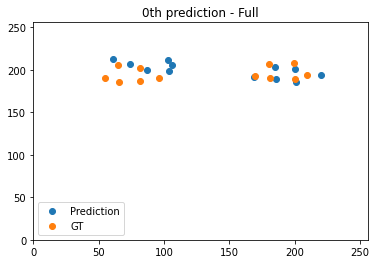

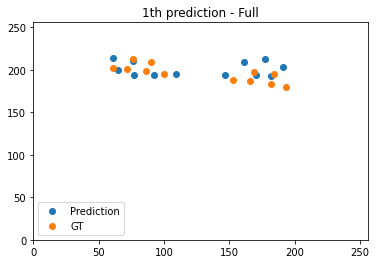

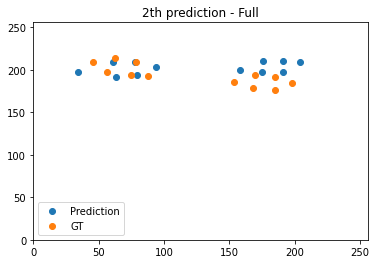

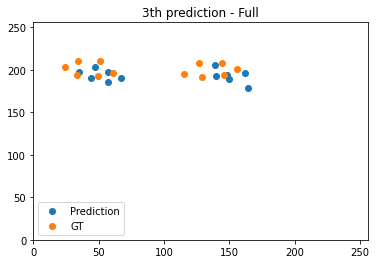

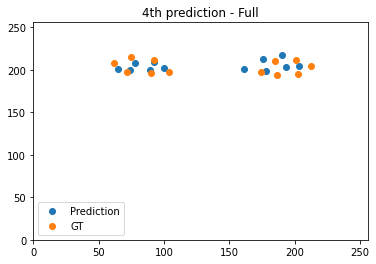

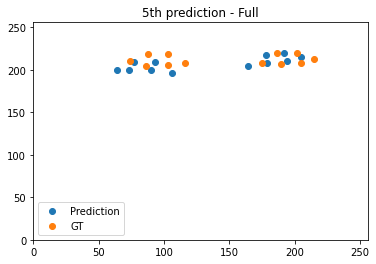

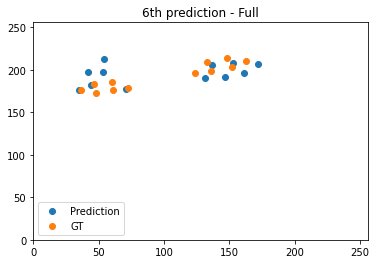

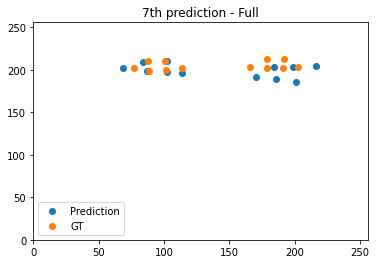

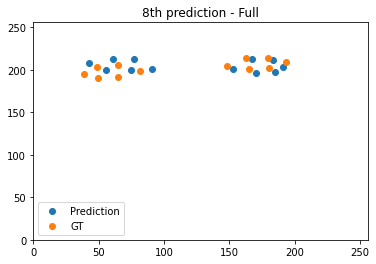

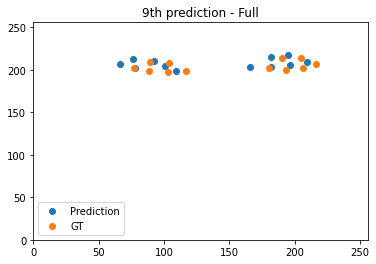

In [ ]:
# Coords

for ith in range(10):
  x = pred_coord0[ith,::2].detach().cpu()
  y = pred_coord0[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction")

  x2 = coord[ith,36:48,0].detach().cpu()
  y2 = coord[ith,36:48,1].detach().cpu()
  plt.scatter(x2,256-y2,label="GT")

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th prediction - Full")
  plt.show()

In [ ]:
# Coords

for ith in range(10):
  x = pred_coords[ith,::2].detach().cpu()
  y = pred_coords[ith,1::2].detach().cpu()
  plt.scatter(x,256-y,label="Prediction")

  x2 = coord[ith,36:48,0].detach().cpu()
  y2 = coord[ith,36:48,1].detach().cpu()
  plt.scatter(x2,256-y2,label="GT")

  plt.legend(loc='lower left')
  plt.xlim(0,256)
  plt.ylim(0,256)
  plt.title(str(ith)+"th prediction - Selected")
  plt.show()

NameError: ignored

In [ ]:
plot_heatmaps = pred_heatmaps.reshape(B,12,256,256).detach().cpu()
plot_heatmaps_all = torch.sum(plot_heatmaps,axis=1)
for ith in range(10):
  plt.imshow(plot_heatmaps_all[ith,:,:])
  plt.title(str(ith)+"th prediction heatmap")
  plt.show()

In [ ]:
for nleaf in range(48):
  plt.imshow(leaf_q.reshape(total_num_leaf_nodes,12,256,256)[nleaf,0,:,:].detach().cpu())
  plt.title(str(ith)+"th leafnode, first point, first img")
  plt.show()

In [ ]:
image = torch.sum(hm, axis=1).detach().cpu()
plt.imshow(image[ith,:,:])

In [ ]:
plt.imshow(img[ith,:,:,:].detach().cpu().permute(1,2,0).int())